# Introdução à Ciência de Dados - Projeto Parte 2

<p align="justify">
Nessa etapa, iremos escolher uma das colunas do nosso dataset para para fazermos uma regressão baseada nas demais features. Avaliaremos quatro diferentes algoritmos para essa tarefa e utilizaremos o MLFlow para fazer o rastreamento. Adicionalmente, usaremos o Optuna para variar os hiperparâmetros de cada abordagem e escolher o melhor deles.

### Equipe:
> Pedro Henrique Almeida Girão Peixinho (phagp)

> Victor Gabriel de Carvalho (vgc3)

### Tópicos Avançados em Gerenciamento de Dados e Informação IF697 - 2024.1 - Centro de Informáica UFPE

In [180]:
import pandas as pd
import numpy as np

from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import optuna
# import autosklearn.regression

tf.random.set_seed(9)
keras.utils.set_random_seed(9)

In [181]:
df_cars = pd.read_csv('carscraper\cars.csv')
df_cars.head()

,page,car_brand,car_name,car_price,car_km,car_year,car_desc,car_store,car_engine,car_gearbox,car_fuel,car_color
0,https://grupoautonunes.com/estoque/?zero_km=0&...,Fiat,500E,125990.0,7521.0,2022,ICON ELÉTRICO,NaN,Elétrico,Automatico,Elétrico,NaN
1,https://grupoautonunes.com/estoque/?zero_km=0&...,Audi,Q3,128980.0,40000.0,2018,1.4 TFSI AMBIENTE FLEX 4P S TRONIC,NaN,1.4,Automatico,Flex,NaN
2,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,70990.0,40686.0,2023,1.0 FLEX LT MANUAL,NaN,1.0,Manual,Flex,NaN
3,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,79990.0,57643.0,2022,1.0 TURBO FLEX PLUS LTZ AUTOMÁTICO,NaN,1.0 Turbo,Automatico,Flex,NaN
4,https://grupoautonunes.com/estoque/?zero_km=0&...,Volkswagen,Saveiro,77990.0,29000.0,2023,1.6 MSI TRENDLINE CS 8V FLEX 2P MANUAL,NaN,1.6,Manual,Flex,NaN


In [182]:
df_cars.shape

(1124, 12)

In [183]:
df_cars.drop(['page', 'car_desc'], axis=1, inplace=True)
df_cars.drop_duplicates(inplace=True)

df_cars.head()

,car_brand,car_name,car_price,car_km,car_year,car_store,car_engine,car_gearbox,car_fuel,car_color
0,Fiat,500E,125990.0,7521.0,2022,NaN,Elétrico,Automatico,Elétrico,NaN
1,Audi,Q3,128980.0,40000.0,2018,NaN,1.4,Automatico,Flex,NaN
2,Chevrolet,Onix,70990.0,40686.0,2023,NaN,1.0,Manual,Flex,NaN
3,Chevrolet,Onix,79990.0,57643.0,2022,NaN,1.0 Turbo,Automatico,Flex,NaN
4,Volkswagen,Saveiro,77990.0,29000.0,2023,NaN,1.6,Manual,Flex,NaN


In [184]:
df_cars.dtypes

car_brand       object
car_name        object
car_price      float64
car_km         float64
car_year         int64
car_store       object
car_engine      object
car_gearbox     object
car_fuel        object
car_color       object
dtype: object

In [185]:
df_cars_cat = df_cars.copy()
object_columns = df_cars.select_dtypes(['object']).columns
df_cars_cat[object_columns] = df_cars[object_columns].astype('category')

df_cars_cat.dtypes

car_brand      category
car_name       category
car_price       float64
car_km          float64
car_year          int64
car_store      category
car_engine     category
car_gearbox    category
car_fuel       category
car_color      category
dtype: object

In [186]:
df_cars_cat.isnull().sum()

car_brand         0
car_name          0
car_price         0
car_km            0
car_year          0
car_store      1095
car_engine        0
car_gearbox       0
car_fuel         48
car_color       986
dtype: int64

In [187]:
df_cars_cat.dropna(thresh=0.7*len(df_cars_cat), axis=1, inplace=True)
df_cars_cat.count()

car_brand      1103
car_name       1103
car_price      1103
car_km         1103
car_year       1103
car_engine     1103
car_gearbox    1103
car_fuel       1055
dtype: int64

In [188]:
df_cars_codes = df_cars_cat.copy()
category_columns = df_cars_cat.select_dtypes(['category']).columns
df_cars_codes[category_columns] = df_cars_cat[category_columns].apply(lambda x: x.cat.codes.replace(-1, np.nan))

df_cars_codes.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,8,9,125990.0,7521.0,2022,29,0,1.0
1,1,108,128980.0,40000.0,2018,6,0,2.0
2,6,96,70990.0,40686.0,2023,0,1,2.0
3,6,96,79990.0,57643.0,2022,1,0,2.0
4,29,122,77990.0,29000.0,2023,10,1,2.0


---

In [189]:
# imputer = KNNImputer(n_neighbors=5)
# knn_fill = imputer.fit_transform(df_cars_codes)
# df_knn_fill = pd.DataFrame(data=knn_fill, columns=[df_cars_codes.columns])

# df_knn_fill.head()

In [190]:
# df_knn_fill_ee = df_knn_fill.copy()

# detector = EllipticEnvelope(contamination=0.01, support_fraction=0.85)
# detector.fit(df_knn_fill_ee)

In [191]:
# scores = detector.predict(df_knn_fill_ee)
# df_knn_fill_ee['outlier'] = scores

# df_knn_fill_ee.head()

In [192]:
# df_knn_fill_ee = df_knn_fill_ee[df_knn_fill_ee['outlier'] != -1]
# df_knn_fill_ee.head()

---

In [193]:
df_median_fill = df_cars_codes.copy()

df_median_fill['car_fuel'] = df_median_fill['car_fuel'].fillna(df_median_fill['car_fuel'].median())
df_median_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [194]:
df_median_fill_ee = df_median_fill.copy()

detector = EllipticEnvelope(contamination=0.01, support_fraction=0.85)
detector.fit(df_median_fill_ee)

scores = detector.predict(df_median_fill_ee)
df_median_fill_ee['outlier'] = scores

df_median_fill_ee['outlier'] = df_median_fill_ee['outlier'].astype('int')

df_median_fill_ee.head()

df_median_fill_ee = df_median_fill_ee[df_median_fill_ee['outlier'] != -1]
df_median_fill_ee.drop('outlier', axis=1, inplace=True)
df_median_fill_ee.count()

car_brand      1091
car_name       1091
car_price      1091
car_km         1091
car_year       1091
car_engine     1091
car_gearbox    1091
car_fuel       1091
dtype: int64

In [195]:
min_max_scaler = MinMaxScaler()
df_knn_fill_norm = min_max_scaler.fit_transform(df_median_fill_ee)
df_knn_fill_norm = pd.DataFrame(df_knn_fill_norm, columns=df_median_fill_ee.columns)
df_knn_fill_norm.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,0.266667,0.057325,0.175680,0.011500,0.88,1.000000,0.0,0.2
1,0.033333,0.687898,0.180880,0.061162,0.72,0.206897,0.0,0.4
2,0.200000,0.611465,0.080013,0.062211,0.92,0.000000,1.0,0.4
3,0.200000,0.611465,0.095667,0.088139,0.88,0.034483,0.0,0.4
4,0.966667,0.777070,0.092188,0.044343,0.92,0.344828,1.0,0.4


---

## Modelos de Inferência 

In [196]:
X_train, X_test, y_train, y_test = train_test_split(df_knn_fill_norm.drop('car_price', axis=1), df_knn_fill_norm['car_price'], test_size=0.2, random_state=9)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=9)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(872, 7) (110, 7) (109, 7)
(872,) (110,) (109,)


---

### Linear Regression

In [197]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_val, y_val)

0.5063485534942351

In [198]:
lin_reg_pred = lin_reg.predict(X_test)

---

### Random Forest Regressor

In [199]:
rf_reg = RandomForestRegressor(n_estimators=100, criterion='squared_error', min_samples_split=2, random_state=9)
rf_reg.fit(X_train, y_train)
rf_reg.score(X_val, y_val)

0.6994450151691001

In [200]:
rf_reg_pred = rf_reg.predict(X_test)

---

### Gradient Boosting Regressor

In [201]:
gb_reg = GradientBoostingRegressor(loss='squared_error', n_estimators=100, random_state=9)
gb_reg.fit(X_train, y_train)
gb_reg.score(X_val, y_val)

0.8066778883652442

In [202]:
gb_reg_pred = gb_reg.predict(X_test)

---

### Artificial Neural Network

In [203]:
nn_reg = tf.keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(0.001)
nn_reg.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'r2_score'])

nn_reg.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nn_reg.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0264 - mae: 0.0882 - r2_score: -0.0590 - val_loss: 0.0124 - val_mae: 0.0619 - val_r2_score: 0.3162
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0682 - r2_score: 0.3256 - val_loss: 0.0116 - val_mae: 0.0550 - val_r2_score: 0.3583
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0631 - r2_score: 0.3525 - val_loss: 0.0112 - val_mae: 0.0542 - val_r2_score: 0.3805
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0625 - r2_score: 0.3766 - val_loss: 0.0107 - val_mae: 0.0532 - val_r2_score: 0.4088
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0614 - r2_score: 0.3965 - val_loss: 0.0101 - val_mae: 0.0520 - val_r2_score: 0.4420
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0605 - r2_score: 0.4183 - val_loss: 0.0097 - val_mae: 0.0515 - val_r2_score: 0.4662
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [205]:
nn_reg.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - mae: 0.0361 - r2_score: 0.8046 


[0.004316628444939852, 0.03915241360664368, 0.7429929971694946]

In [206]:
nn_reg_pred = nn_reg.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


---

## Avaliação e Comparações

In [216]:
X_test['lin_reg_pred'] = lin_reg_pred
X_test['rf_reg_pred'] = rf_reg_pred
X_test['gb_reg_pred'] = gb_reg_pred
X_test['nn_reg_pred'] = nn_reg_pred
X_test['car_price'] = y_test

X_test.head()

,car_brand,car_name,car_km,car_year,car_engine,car_gearbox,car_fuel,lin_reg_pred,rf_reg_pred,gb_reg_pred,nn_reg_pred,car_price
964,0.200000,0.668790,0.0,0.76,0.206897,0.0,0.4,0.002104,0.050492,0.050388,0.077348,0.064201
951,0.433333,0.719745,0.0,0.96,0.172414,0.0,0.4,0.155072,0.241463,0.199692,0.158229,0.182481
985,1.000000,0.980892,0.0,0.88,0.448276,0.0,1.0,0.100765,0.036306,0.035778,0.072598,0.634812
708,0.266667,0.885350,0.0,0.84,0.413793,0.0,0.4,0.154451,0.072187,0.075732,0.097398,0.130299
655,0.800000,0.528662,0.0,0.80,0.000000,1.0,0.4,0.134126,0.131445,0.125462,0.146008,0.027674


In [217]:
X_test.sort_values(by='car_km', inplace=True)

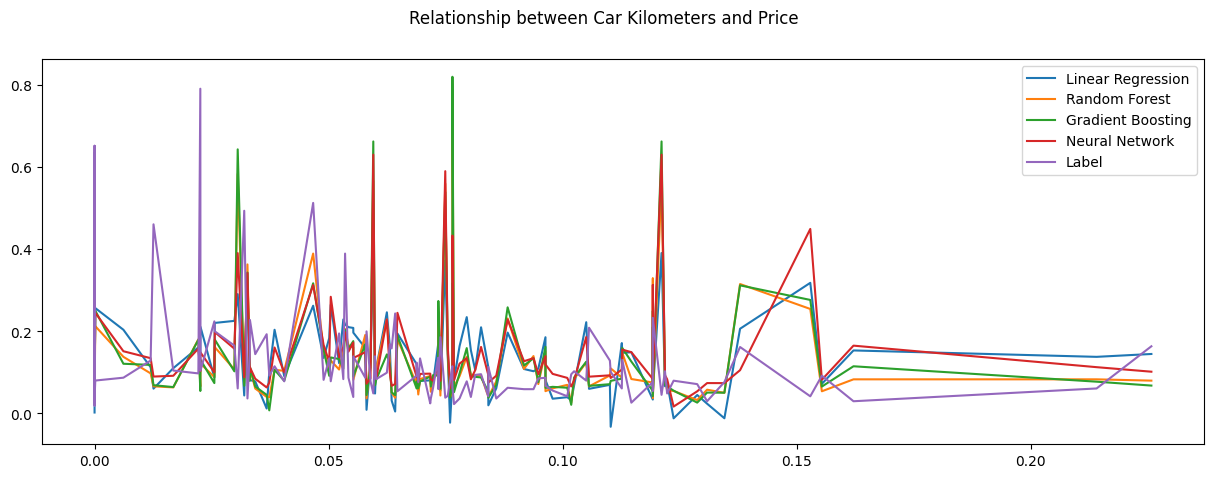

In [224]:
fig, ax = plt.subplots(figsize=(15, 5))

fig.suptitle('Relationship between Car Kilometers and Price')

ax.plot(X_test['car_km'], X_test['lin_reg_pred'], label='Linear Regression')
ax.plot(X_test['car_km'], X_test['rf_reg_pred'], label='Random Forest')
ax.plot(X_test['car_km'], X_test['gb_reg_pred'], label='Gradient Boosting')
ax.plot(X_test['car_km'], X_test['nn_reg_pred'], label='Neural Network')
ax.plot(X_test['car_km'], X_test['car_price'], label='Label')

plt.legend()
plt.show()

---

## Referêncais

Data Treatment
- https://pypi.org/project/fancyimpute/#description

Regression Models
- [Linear Regression] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- [Random Forest Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- [Gradient Boosting Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
- [Neural Network Rsgressor] https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

Further Reading
- https://keras.io/examples/keras_recipes/reproducibility_recipes/

Automated Optimization
- https://optuna.org/
- https://automl.github.io/auto-sklearn/master/index.html

Didactic Material
- https://towardsdatascience.com/7-of-the-most-commonly-used-regression-algorithms-and-how-to-choose-the-right-one-fc3c8890f9e3